In [103]:
import numpy as np
import matplotlib.pyplot as plt

### Fitting elliptical data 1: fit to 1D ellipse curve

Electron diffraction patterns will, as a general rule, contain some elliptical distortions.  The first step in handling these is measuring them.  Here we demonstrate the first of two approaches to measuring elliptical distortions in py4DSTEM, where data within some specified annulus is fit is to a 1D elliptical curve.

In [138]:
from matplotlib.patches import Circle, Ellipse
from py4DSTEM.process.utils import fit_ellipse_inside_annulus

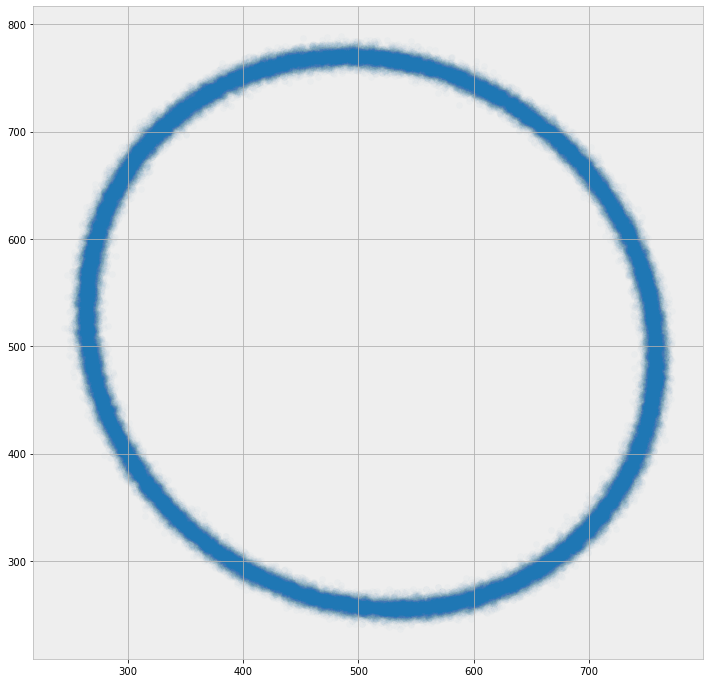

In [139]:
# Make test data
# (x,y points)

L = 1024
N = 100000

x0 = 511
y0 = 513
A = 240
B = 264
phi = np.radians(32)

sigma_r = 0.02

# Define coords
yy,xx = np.meshgrid(np.arange(L),np.arange(L))

# Define datapoints in (r,theta)
theta = np.random.uniform(0,2*np.pi,N)
r = np.random.normal(1,sigma_r,size=N)

# Get points in (x,y)
x = x0 + A*r*np.cos(theta)*np.cos(phi) - B*r*np.sin(theta)*np.sin(phi)
y = y0 + B*r*np.sin(theta)*np.cos(phi) + A*r*np.cos(theta)*np.sin(phi)

# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.scatter(x,y,alpha=0.02)
plt.show()

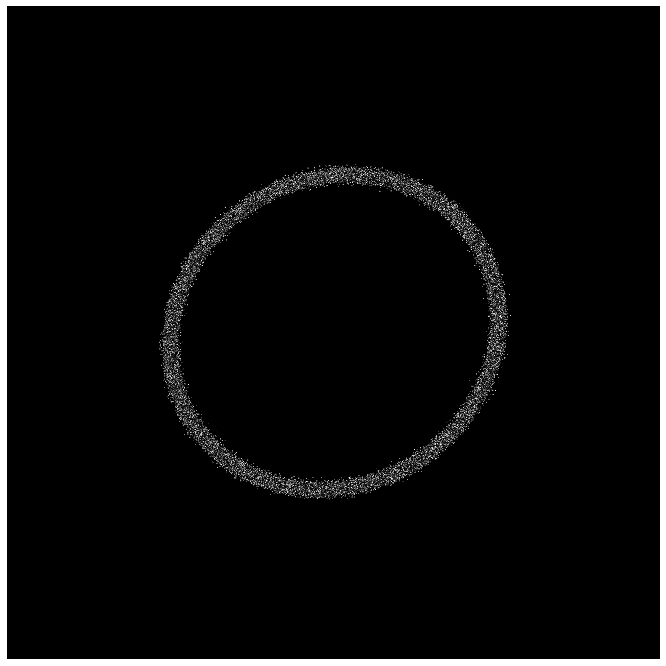

In [140]:
# Make test data
# (data array)

data = np.zeros((L,L))

xF,yF = np.floor(x),np.floor(y)
dx,dy = x-xF,y-yF
weights = np.hstack(((1-dx)*(1-dy),
                     (1-dx)*(  dy),
                     (  dx)*(1-dy),
                     (  dx)*(  dy)))
x_inds = np.hstack((xF,xF,xF+1,xF+1))
y_inds = np.hstack((yF,yF+1,yF,yF+1))

data[x_inds.astype(int),y_inds.astype(int)] += weights

# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(data,cmap='gray')
ax.axis('off')
plt.show()

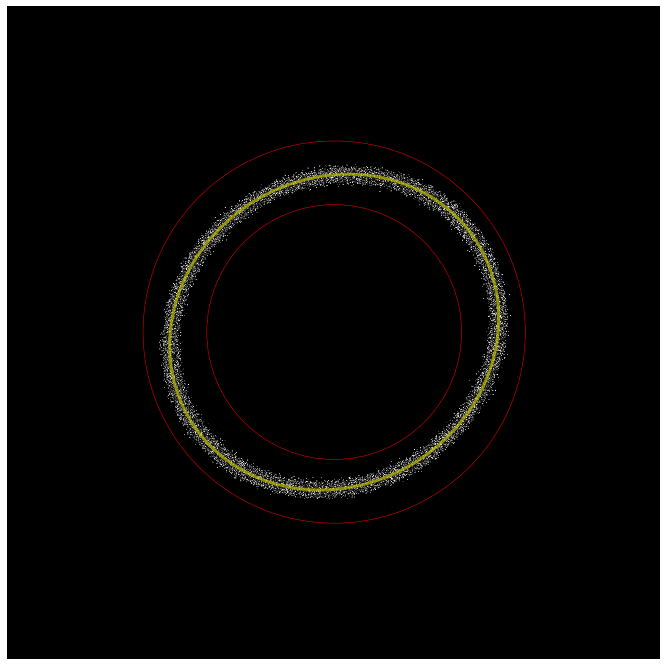

In [141]:
# Fit an ellipse

xc,yc = 512,512
r_inner = 200
r_outer = 300

ellipse_params = fit_ellipse_inside_annulus(data, xc, yc, r_inner, r_outer)
x0_,y0_,A_,B_,phi_ = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(data,cmap='gray')
circle_inner = Circle((y0_,x0_),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0_,x0_),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y0_,x0_),2*A_,2*B_,90-np.degrees(phi_), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
ax.axis('off')
plt.show()

In [142]:
print("{:.2f}% error in x0".format(100*(x0-x0_)/x0_))
print("{:.2f}% error in y0".format(100*(y0-y0_)/y0_))
print("{:.2f}% error in A".format(100*(A-A_)/A_))
print("{:.2f}% error in B".format(100*(B-B_)/B_))
print("{:.2f}% error in phi".format(100*(phi-phi_)/phi_))
r_ab,r_ab_ = float(A)/B, A_/B_
print("{:.2f}% error in A/B".format(100*(r_ab-r_ab_)/r_ab_))

0.08% error in x0
0.04% error in y0
-0.33% error in A
-0.34% error in B
-0.50% error in phi
0.01% error in A/B


### Fitting elliptical data 2: double-sided gaussian fits

Here we fit the data to a slightly more complicated function.  Here, we model the data roughly as a plasmonic background (a centrocymmetric gaussian + constant offset) plus an elliptical ring.  The elliptical ring intensity decays at different rates towards and away from the origin.

In [143]:
from py4DSTEM.process.utils import convert_ellipse_params
from py4DSTEM.process.utils import double_sided_gaussian

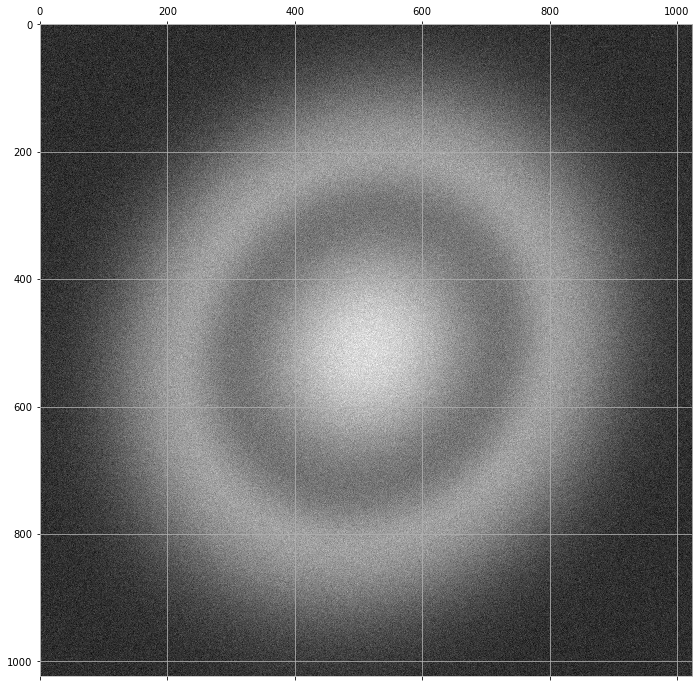

In [144]:
# Generate data

L = 1024

I0 = 8200
I1 = 4700
sigma0 = 140
sigma1 = 52
sigma2 = 88
c_bkgd = 1000
R = 312
x0 = 511.3
y0 = 512.99
A = 1
B = 0.24
C = 1.1

noise = 500

# Get coords
yy,xx = np.meshgrid(np.arange(L),np.arange(L))
r2 = A*(xx-x0)**2 + B*(xx-x0)*(yy-y0) + C*(yy-y0)**2
r = np.sqrt(r2)

# Make data
data = I0*np.exp(-r2/(2*sigma0**2)) + \
       I1*np.exp(-(r-R)**2/(2*sigma1**2))*np.heaviside(R-r,0.5) + \
       I1*np.exp(-(r-R)**2/(2*sigma2**2))*np.heaviside(r-R,0.5) + c_bkgd
data = data + np.random.normal(0,noise,size=data.shape)
        
# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(data)
plt.show()

In [145]:
# fit data

from py4DSTEM.process.utils import fit_double_sided_gaussian

p0 = (8300,4500,130,55,89,1010,352,511.3,513.99,1,0.24,1.1)
dsg_params = fit_double_sided_gaussian(data, p0, mask=None)

A,B,phi = convert_ellipse_params(dsg_params[9],dsg_params[10],dsg_params[11])
x0,y0 = dsg_params[7:9]
R = dsg_params[6]

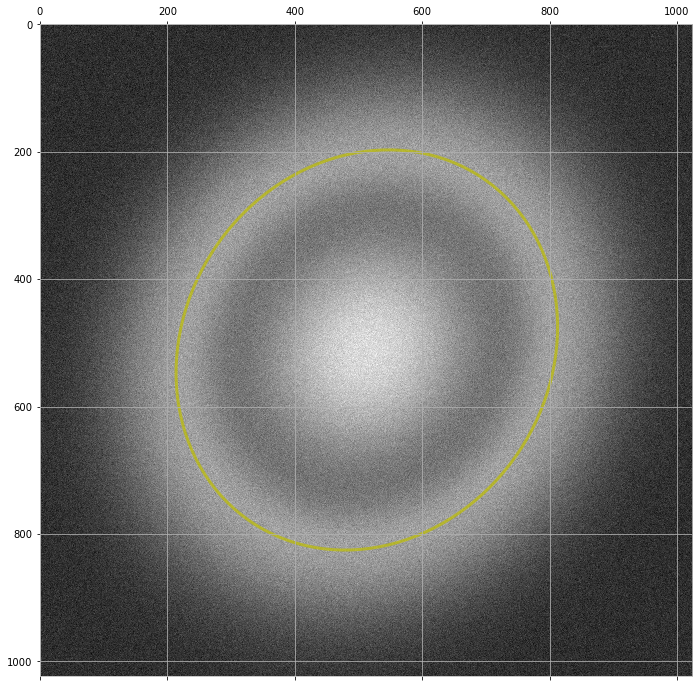

In [146]:
# display results

ellipse = Ellipse((y0,x0),2*A*R,2*B*R,90-np.degrees(phi), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)

# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(data)
ax.add_patch(ellipse)
plt.show()

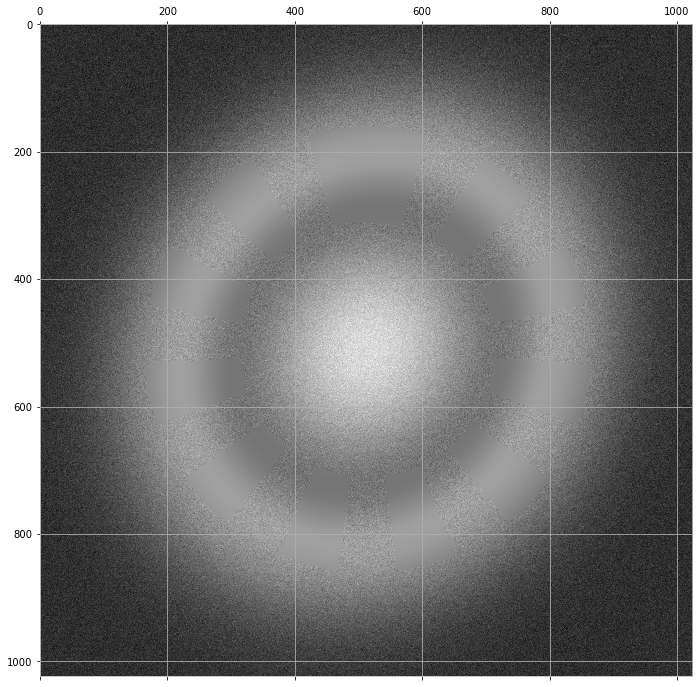

In [147]:
# display results
# colin-style visualization

r_inner = 200
r_outer = 350
N_pinwheel = 24  # Even number

# Make coords
yy,xx = np.meshgrid(np.arange(L),np.arange(L))
x,y = xx-x0,yy-y0
r = np.hypot(x,y)
r2 = r**2
theta = np.arctan2(y,x)

# Make mask
thetas = np.linspace(-np.pi,np.pi,N_pinwheel)
pinwheel = np.zeros((L,L))
for i in range(len(thetas[::2])):
    pinwheel += (theta<thetas[1::2][i]) * (theta>=thetas[::2][i])
mask = pinwheel * (r>r_inner) * (r<=r_outer)

# Get fit
fit = double_sided_gaussian(dsg_params,xx,yy)

data_ma = np.ma.array(data=data, mask=mask)
fit_ma = np.ma.array(data=fit, mask=mask==False)

# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(data_ma,vmin=np.min(data),vmax=np.max(data))
ax.matshow(fit_ma,vmin=np.min(data),vmax=np.max(data))
plt.show()

### Elliptical data application 1: the polar elliptical transform

Electron diffraction patterns will, as a general rule, contain some elliptical distortions.  A polar-elliptical transformation -- resampling the data into a polar-elliptical coordinate system -- can effectively correct these distortions, given the right selection of ellipse.

In [148]:
from py4DSTEM.process.utils import cartesianDataAr_to_polarEllipticalDataAr

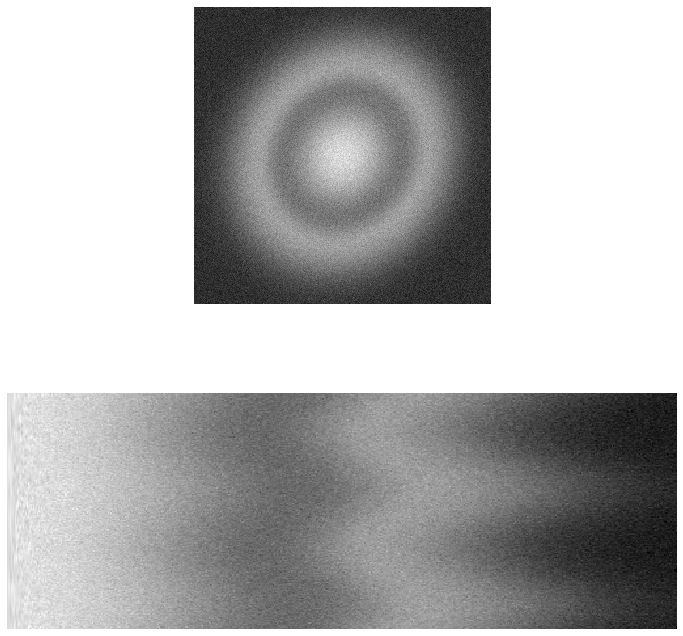

In [149]:
# Polar transform (i.e. A=B)
ellipse_params = (x0_,y0_,1,1,0)

polarData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                    cartesianData=data,
                    params=ellipse_params,
                    dr=1,
                    r_range=512,
                    dtheta=np.radians(2),
                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(data)
#ax1.scatter(y0_,x0_,color='r')
ax2.matshow(polarData.data)
ax1.axis('off')
ax2.axis('off')
plt.show()

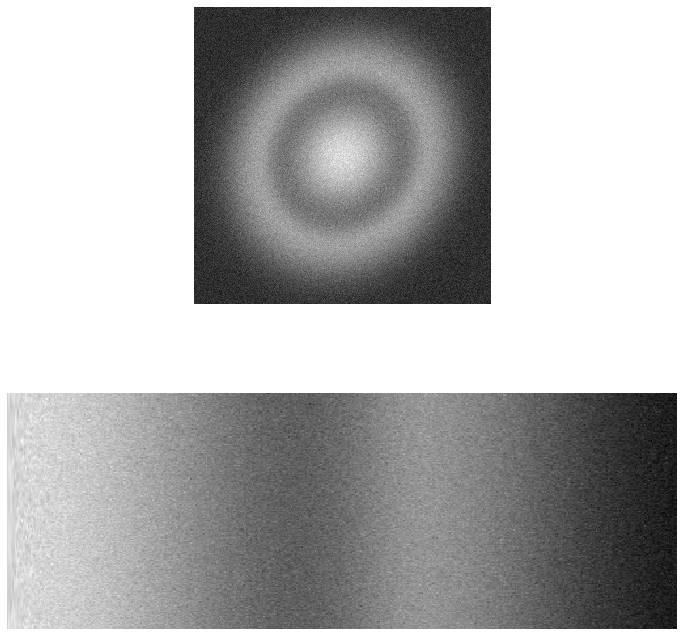

In [150]:
# Polar-elliptical transform

ellipse_params = (x0,y0,1,B/A,phi)

polarEllipticalData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                                    cartesianData=data,
                                    params=ellipse_params,
                                    dr=1,
                                    r_range=512,
                                    dtheta=np.radians(2),
                                    mask=None
)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(data)
#ax1.scatter(y0_,x0_,color='r')
ax2.matshow(polarEllipticalData.data)
ax1.axis('off')
ax2.axis('off')
plt.show()

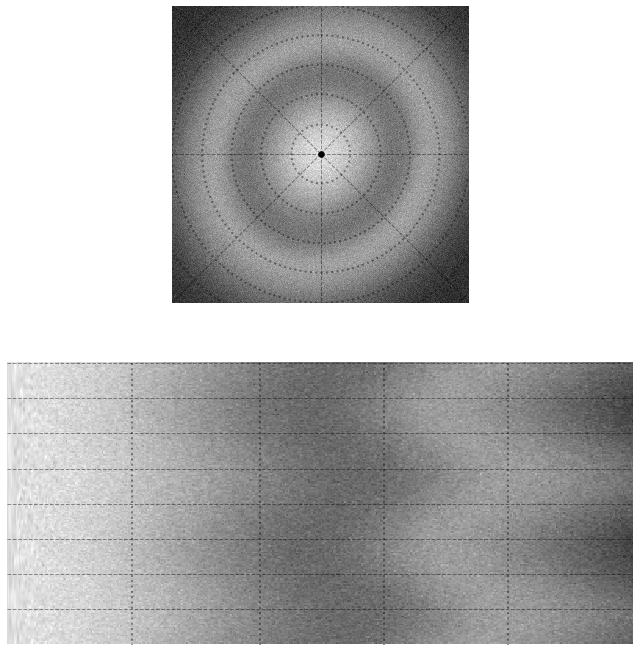

In [151]:
# Polar transform, with coordinate lines

color_axes = 'k'
alpha_axes = 0.4
r_vals = [0.33,0.67,1,1.33,1.67,2]
circles = []
for i,r_val in enumerate(r_vals):
    circle = Circle((y0_,x0_),r_val*A_, fill=False,ec=color_axes,ls=":",lw=2, alpha=alpha_axes)
    circles.append(circle)

def get_xfyf(x0,y0,theta):
    R = 600
    xf = x0 + A_*R*np.cos(theta)
    yf = y0 + A_*R*np.sin(theta)
    return xf,yf

Nt,Nr = polarData.data.shape
    
# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.scatter(y0_,x0_,color=color_axes)
for circle in circles:
    ax1.add_patch(circle)
for theta in np.linspace(0,2*np.pi,8,endpoint=False):
    xf,yf = get_xfyf(x0_,y0_,theta)
    ax1.plot((y0_,yf),(x0_,xf),color=color_axes,lw=1,ls='--',alpha=alpha_axes)
ax1.matshow(data)
ax1.set_xlim(x0_-400,x0+400)
ax1.set_ylim(y0_-400,y0+400)
ax1.invert_yaxis()
ax1.axis('off')

ax2.matshow(polarData.data)
ax2.hlines(np.linspace(0,Nt,8,endpoint=False),0,Nr,color=color_axes,lw=1,ls='--',alpha=alpha_axes)
ax2.vlines(np.array(r_vals)*A_,0,Nt,color=color_axes,ls=":",lw=2, alpha=alpha_axes)
ax2.set_xlim(0,400)
ax2.axis('off')
plt.show()

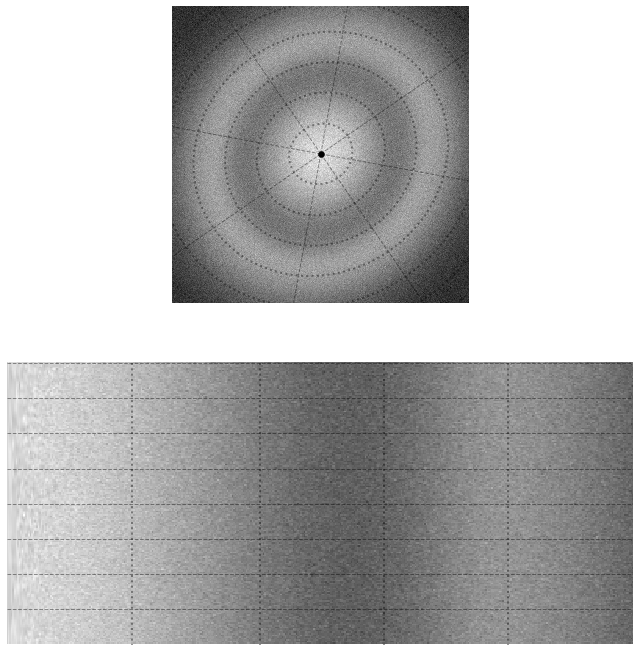

In [152]:
# Polar-elliptical transform, with coordinate lines

color_axes = 'k'
alpha_axes = 0.4
r_vals = [0.33,0.67,1,1.33,1.67,2]
ellipses = []
for i,r_val in enumerate(r_vals):
    ellipse = Ellipse((y0_,x0_),r_val*2*A_,r_val*2*B_,90-np.degrees(phi_), fill=False,ec=color_axes,ls=":",lw=2, alpha=alpha_axes)
    ellipses.append(ellipse)

def get_xfyf(x0,y0,theta,phi):
    R = 600
    xf = x0 + A_*R*np.cos(theta)*np.cos(phi) - B_*R*np.sin(theta)*np.sin(phi)
    yf = y0 + B_*R*np.cos(theta)*np.sin(phi) + A_*R*np.sin(theta)*np.cos(phi)
    return xf,yf

Nt,Nr = polarEllipticalData.data.shape
    
# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.scatter(y0_,x0_,color=color_axes)
for ellipse in ellipses:
    ax1.add_patch(ellipse)
for theta in np.linspace(0,2*np.pi,8,endpoint=False):
    xf,yf = get_xfyf(x0_,y0_,theta,phi_)
    ax1.plot((y0_,yf),(x0_,xf),color=color_axes,lw=1,ls='--',alpha=alpha_axes)
ax1.matshow(data)
ax1.set_xlim(x0_-400,x0+400)
ax1.set_ylim(y0_-400,y0+400)
ax1.invert_yaxis()
ax1.axis('off')

ax2.matshow(polarEllipticalData.data)
ax2.hlines(np.linspace(0,Nt,8,endpoint=False),0,Nr,color=color_axes,lw=1,ls='--',alpha=alpha_axes)
ax2.vlines(np.array(r_vals)*A_,0,Nt,color=color_axes,ls=":",lw=2, alpha=alpha_axes)
ax2.set_xlim(0,400)
ax2.axis('off')
plt.show()

### Elliptical data application 2: ellipse-corrected radial integrals

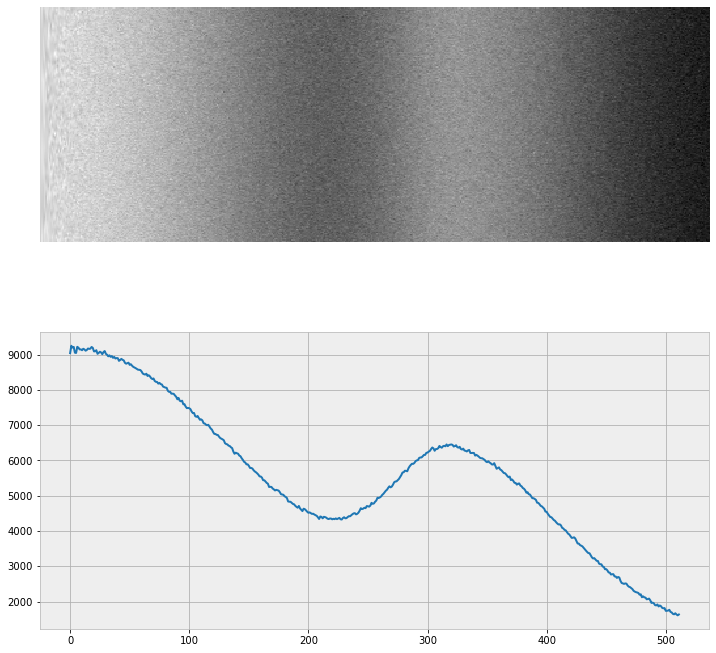

In [153]:
# Polar-elliptical transform

ellipse_params = (x0,y0,1,B/A,phi)

polarEllipticalData,rr,tt = cartesianDataAr_to_polarEllipticalDataAr(
                                    cartesianData=data,
                                    params=ellipse_params,
                                    dr=1,
                                    r_range=512,
                                    dtheta=np.radians(2),
                                    mask=None
)

radial_integral = np.mean(polarEllipticalData,axis=0)

# Show
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,12))
ax1.matshow(polarEllipticalData.data)
ax2.plot(np.arange(len(radial_integral)),radial_integral)
ax1.axis('off')
plt.show()

### Elliptical data application 3: masks

### Elliptical data application 4: Elliptical distortion correction to Bragg peak positions

After measuring the elliptical distortions, they can be used to correct the measured Bragg peak positions

In [132]:
from py4DSTEM.file.datastructure import PointListArray
from py4DSTEM.process.braggdiskdetection import get_bragg_vector_map
from py4DSTEM.process.utils import correct_braggpeak_elliptical_distortions

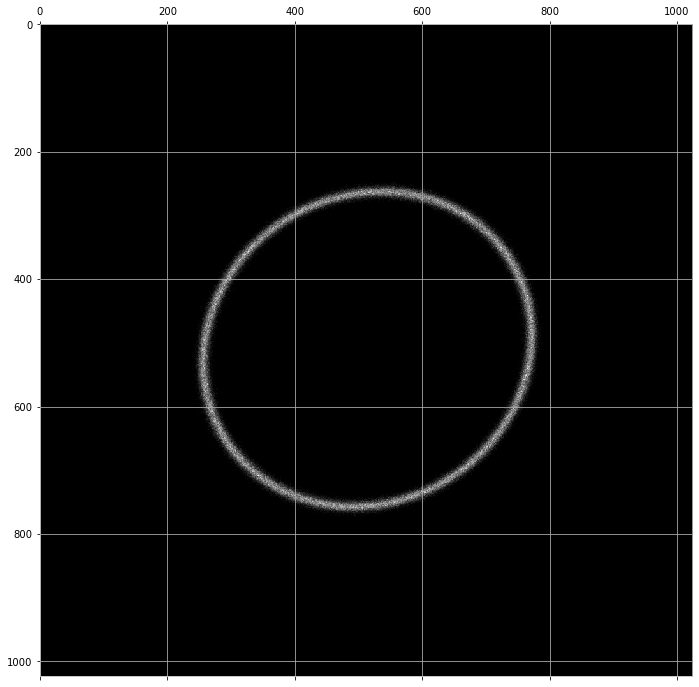

In [133]:
# Make test data
# Bragg peaks PointListArray and bragg vector map

L = 1024
N = 100
Nx,Ny = 50,50

x0 = 511
y0 = 513
A = 240
B = 264
phi = np.radians(32)

sigma_r = 0.02

# Define coords
yy,xx = np.meshgrid(np.arange(L),np.arange(L))

# Make braggpeaks PointListArray
braggpeaks = PointListArray(coordinates=[('qx',float),('qy',float),('intensity',float)], shape=(Nx,Ny))
for Rx in range(Nx):
    for Ry in range(Ny):
        # Define datapoints in (r,theta)
        theta = np.random.uniform(0,2*np.pi,N)
        r = np.random.normal(1,sigma_r,size=N)

        # Get points in (x,y)
        x = x0 + A*r*np.cos(theta)*np.cos(phi) - B*r*np.sin(theta)*np.sin(phi)
        y = y0 + B*r*np.sin(theta)*np.cos(phi) + A*r*np.cos(theta)*np.sin(phi)
        
        # Add to Bragg peaks
        pl = braggpeaks.get_pointlist(Rx,Ry)
        ar = np.zeros(len(x),dtype=[('qx',float),('qy',float),('intensity',float)])
        ar['qx'] = x
        ar['qy'] = y
        ar['intensity'] = np.ones_like(x)
        pl.add_dataarray(ar)
        
# Get bragg vector map
bvm = get_bragg_vector_map(braggpeaks, L, L)
        
# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(bvm)
plt.show()

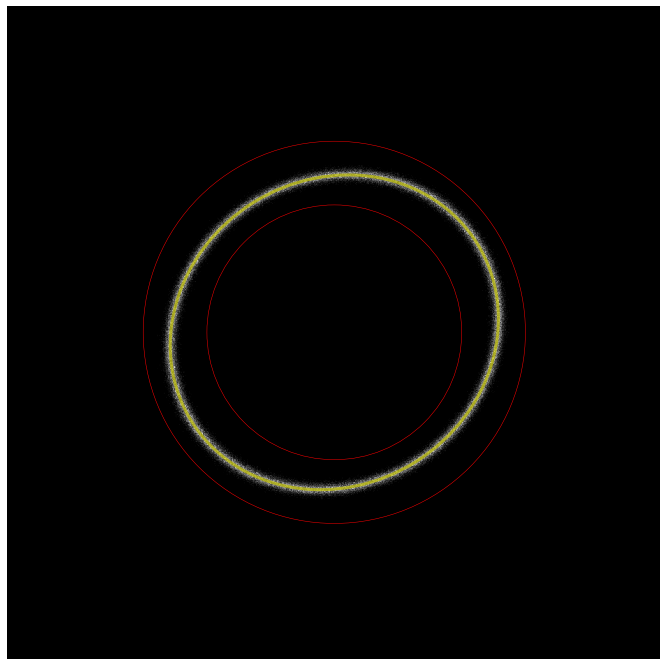

In [134]:
# Fit an ellipse

xc,yc = 512,512
r_inner = 200
r_outer = 300

ellipse_params = fit_ellipse_inside_annulus(bvm, xc, yc, r_inner, r_outer)
x0_,y0_,A_,B_,phi_ = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(bvm,cmap='gray')
circle_inner = Circle((y0_,x0_),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0_,x0_),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y0_,x0_),2*A_,2*B_,90-np.degrees(phi_), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
ax.axis('off')
plt.show()

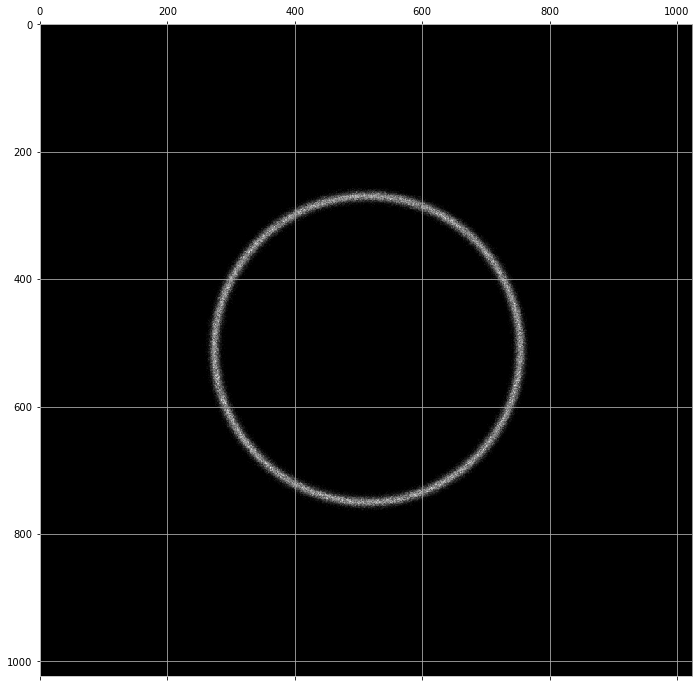

In [135]:
# Correct Bragg peak positions

braggpeaks_corrected = correct_braggpeak_elliptical_distortions(
                                braggpeaks, ellipse_params)

bvm_corrected = get_bragg_vector_map(braggpeaks_corrected, L, L)

# Show
fig,ax = plt.subplots(figsize=(12,12))
ax.matshow(bvm_corrected)
plt.show()

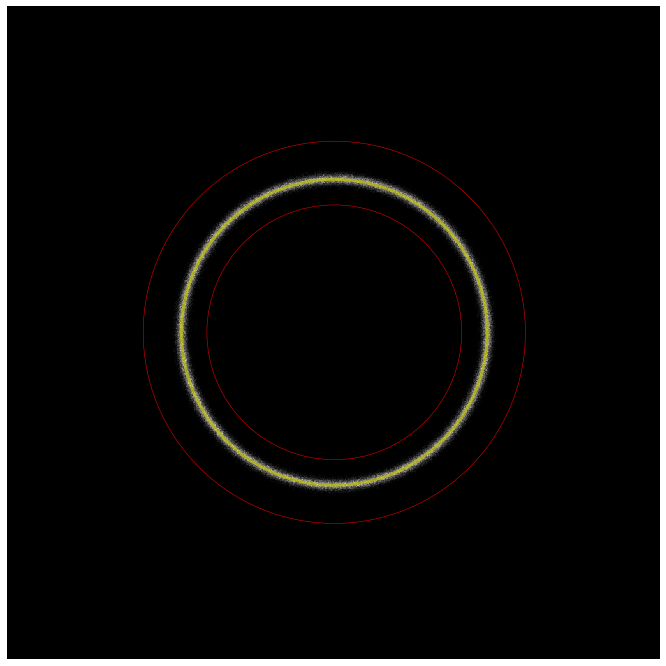

In [136]:
# Fit an ellipse

xc,yc = 512,512
r_inner = 200
r_outer = 300

ellipse_params = fit_ellipse_inside_annulus(bvm_corrected, xc, yc, r_inner, r_outer)
x0_c,y0_c,A_c,B_c,phi_c = ellipse_params

# Show
fig,ax=plt.subplots(figsize=(12,12))
ax.matshow(bvm_corrected,cmap='gray')
circle_inner = Circle((y0_c,x0_c),radius=r_inner, fill=False,edgecolor='r',linestyle="-")
circle_outer = Circle((y0_c,x0_c),radius=r_outer, fill=False,edgecolor='r',linestyle="-")
ellipse = Ellipse((y0_c,x0_c),2*A_c,2*B_c,90-np.degrees(phi_c), fill=False,edgecolor='y',linestyle="-",linewidth=3, alpha=.7)
ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(ellipse)
ax.axis('off')
plt.show()

In [137]:
print("Initial stretch % = {}".format(100*(1-A_/B_)))
print("Final stretch % = {}".format(100*(1-A_c/B_c)))

Initial stretch % = 9.08698913914483
Final stretch % = 0.0004534219606111556


In [19]:
# Elliptical data application 3: FEM

In [20]:
# Elliptical data application 4: RDF

In [21]:
# Elliptical data application 3: Amorphous strain
# - measure the ellipse of an amorphous ring, by scan position
# - convert ellipse params to e_xx,e_yy,theta

In [22]:
# Masks
# Masks for fitting
# Masked transforms